In [ ]:
!unzip dataset.zip

In [ ]:
# !pip install pytorch-lightning-bolts

In [ ]:
!pip install pytorch-lightning==1.7.3
!pip install lightning-bolts

In [ ]:
import torch
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os 
from torchvision.io import read_image
from PIL import Image

In [ ]:
class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

# These transformations are as described in the SimCLR paper
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=224),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1)], p=0.8),
        # transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=21),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, image_list, transform=None):
    self.image_list = image_list
    self.transform = transform
    
  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):
    img_path = self.image_list[idx]
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)
    return image

In [ ]:
# visualize dataset
image_list = os.listdir()
image_list.remove('.config')
image_list.remove('dataset.zip')
image_list.remove('sample_data')
# image_list.remove('lightning_logs')
# image_list.remove('.ipynb_checkpoints')
for i in range(len(image_list)):
  image_list[i] = os.path.join(image_list[i], 'image_2.jpg')

unlabeled_data = ImageDataset(image_list, ContrastiveTransformations(contrast_transforms, n_views=2))
NUM_IMAGES = 6

cols = NUM_IMAGES
rows = 2
figure = plt.figure(figsize=(20, 10))
for i in range(1, NUM_IMAGES*2, 2):
    sample_idx = torch.randint(len(unlabeled_data), size=(1,)).item()
    img1, img2 = unlabeled_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img1.movedim(0, -1))
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img2.movedim(0, -1))
plt.show()

## SimCLR from pytorch lightning

In [ ]:
from pl_bolts.models.self_supervised import SimCLR
import pytorch_lightning as pl

In [ ]:
# weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
weight_path = '/content/epoch=96-step=8536.ckpt'
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False, optimizer='adam')
simclr.freeze()

In [ ]:
frootloops = Image.open('frootloops.jpg')
fruitrings = Image.open('fruit rings.jpg')
specialk = Image.open('special k.jpg')
frootloops2 = Image.open('kellogs_fruit_loops_2.jpg')
fruitrings2 = Image.open('fruit_rings_family_size_2.jpg')
specialk2 = Image.open('Kellogg_s_red_berries_2.jpg')

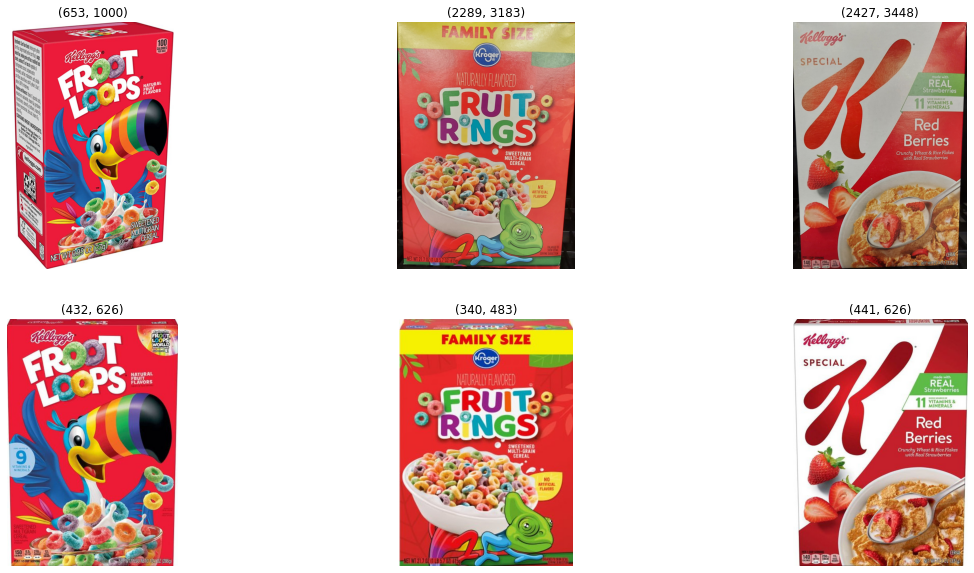

In [ ]:
cols = 3
rows = 2
figure = plt.figure(figsize=(20, 10))
for i, image in enumerate([frootloops, fruitrings, specialk, frootloops2, fruitrings2, specialk2]):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.title(image.size)
    plt.imshow(image)
plt.show()

In [ ]:
eval_transforms = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        # transforms.RandomResizedCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
frootloops = eval_transforms(frootloops)
fruitrings = eval_transforms(fruitrings)
specialk = eval_transforms(specialk)
frootloops2 = eval_transforms(frootloops2)
fruitrings2 = eval_transforms(fruitrings2)
specialk2 = eval_transforms(specialk2)

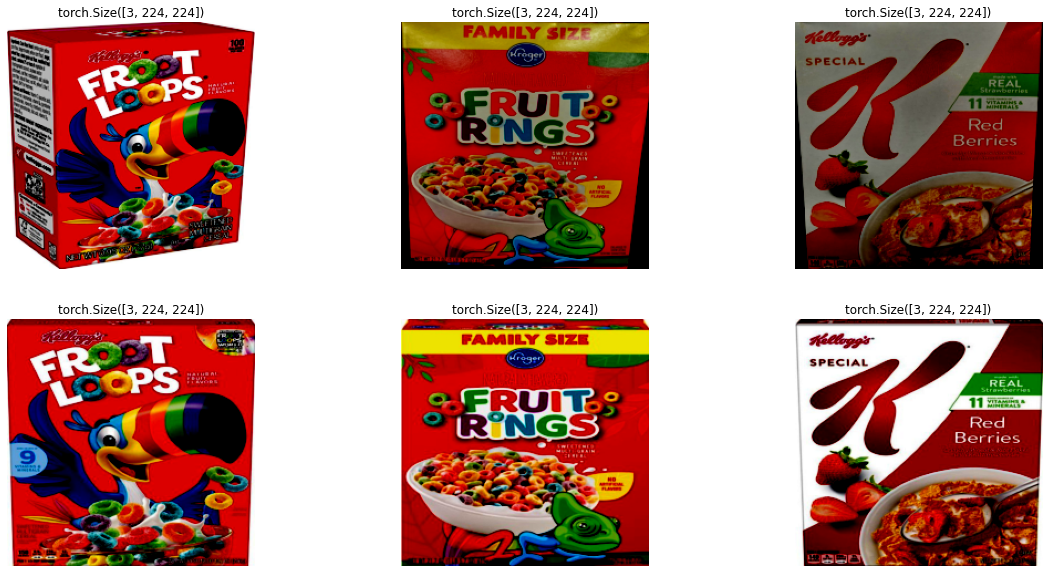

In [ ]:
cols = 3
rows = 2
figure = plt.figure(figsize=(20, 10))
for i, image in enumerate([frootloops, fruitrings, specialk, frootloops2, fruitrings2, specialk2]):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.title(image.shape)
    plt.imshow(image.movedim(0,-1))
plt.show()

In [ ]:
x = frootloops2.reshape((1,3,224,224))
y = specialk.reshape((1,3,224,224))
features_x = simclr.encoder(x)[-1]
features_y = simclr.encoder(y)[-1]
z1 = simclr.projection(features_x)
z2 = simclr.projection(features_y)

In [ ]:
print(torch.cosine_similarity(features_x, features_y))
print(torch.cosine_similarity(z1, z2))

tensor([0.4064])
tensor([0.0271])


In [ ]:
class SimCLRe(pl.LightningModule):
  def __init__(self, model, learning_rate, weight_decay):
    super().__init__()
    self.model = model
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay

  def forward(self, x, learning_rate = 1e-3, weight_decay = 1e-6):
    features = self.model(x)
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
    projections = self.model.projection(features)
    return {'encoder': features, 'projection': projections}
  
  def training_step(self, batch, batch_idx):
    img1, img2 = batch
    z1 = self(img1)['projection']
    z2 = self(img2)['projection']
    loss = self.model.nt_xnet_loss(z1, z2, self.model.temperature)
    return loss
  
  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
    warmup_steps = self.train_iters_per_epoch * self.warmup_epochs
    total_steps = self.train_iters_per_epoch * self.max_epochs
    lr_scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps, total_steps, cosine=True),
            ),
            "interval": "step",
            "frequency": 1,
        }
    return [optimizer], [lr_scheduler]

  def validation_step(self, batch, batch_idx):
    img1, img2 = batch
    z1 = self(img1)['projection']
    z2 = self(img2)['projection']
    loss = self.model.nt_xnet_loss(z1, z2, self.model.temperature)
    return loss

In [ ]:
# model = SimCLRe(model = simclr, learning_rate = 1e-3, weight_decay = 1e-6)
training_loader = DataLoader(unlabeled_data, batch_size=10)

In [ ]:
trainer = pl.Trainer(enable_checkpointing = True, max_epochs=5, default_root_dir='/content/sample_data')
trainer.fit(simclr, train_dataloaders=training_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/simclr/simclr_module.py:220: UnderReviewWarning: The feature linear_warmup_decay is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  linear_warmup_decay(warmup_

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
os.getcwd()

'/content'

In [ ]:
from torch import nn
from torch.autograd import Variable
import numpy as np

In [ ]:
class encoder(nn.Module):
  def __init__(self):
    super(encoder, self).__init__()
    self.conv1 = nn.Conv2d(3,6,kernel_size=(5,5))
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
    self.unconv1 = nn.ConvTranspose2d(6,3,kernel_size=(5,5))
    self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))
    self.unmaxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))

    self.encoder1 = nn.Sequential(
        nn.Tanh(),
        nn.Conv2d(6, 12, kernel_size=(5,5)),
    )
    self.encoder2 = nn.Sequential(
        nn.Tanh(),
        nn.Conv2d(12, 16, kernel_size=(5,5)),
        nn.Tanh(),
    )
  
  def encoder(self, x):
    x = self.conv1(x)
    x, indices1 = self.maxpool1(x)
    x = self.encoder1(x)
    x,indices2 = self.maxpool2(x)
    x = self.encoder2(x)
    return x
  
  def forward(self, x):
    x = self.encoder(x)
    return x

autoencoder_dict = torch.load('coco_color_autoencoder_statedict.pth',map_location=torch.device('cpu'))
encoder_model = encoder().to('cpu')
encoder_dict = encoder_model.state_dict()

autoencoder_dict = {k: v for k, v in autoencoder_dict.items() if k in encoder_dict}

encoder_dict.update(autoencoder_dict)
encoder_model.load_state_dict(autoencoder_dict)
resize = (128, 128)
grid_shape = (5,5)

In [ ]:
encoder_transforms = transforms.Compose(
    [
        transforms.Resize(size=(128,128)),
        # transforms.RandomResizedCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
frootloops = encoder_transforms(frootloops)
fruitrings = encoder_transforms(fruitrings)
specialk = encoder_transforms(specialk)
frootloops2 = encoder_transforms(frootloops2)
fruitrings2 = encoder_transforms(fruitrings2)
specialk2 = encoder_transforms(specialk2)

In [ ]:
x = frootloops.reshape((1,3,128,128))
y = specialk2.reshape((1,3,128,128))
features_x = encoder_model(x)
features_y = encoder_model(y)
features_x = features_x.reshape((1,10000))
features_y = features_y.reshape((1,10000))

In [ ]:
torch.cosine_similarity(features_x, features_y)

tensor([0.6293], grad_fn=<SumBackward1>)

In [ ]:
def get_similarity_score(patch1, patch2, type='euclidean'):
  if type == 'cosine':
    return np.dot(patch1, patch2)/(np.linalg.norm(patch1)*np.linalg.norm(patch2))
  elif type == 'euclidean':
    return np.linalg.norm(patch1/np.linalg.norm(patch1)-patch2/np.linalg.norm(patch2))
  elif type == 'manhattan':
    return np.sum(np.abs(patch1-patch2))